This is a implementation of the paper: "Deep learning to detect botnet via network flow summaries" using Keras.

Dataset:
- https://www.stratosphereips.org/datasets-ctu13

# Feature Extraction

In [39]:
import pandas as pd
from pathlib import Path

columns_ds = ["StartTime", "Dur", "Proto", "SrcAddr", "DstAddr", "State", "TotPkts", "TotBytes", "SrcBytes", "Label"]
def load_datasets(directory, columns_ds):
    import os
    datasets = []
    for root, _, files in os.walk(directory):
        if not files: 
            continue
        for i in range(len(files)):
            if ".binetflow" in files[i]:
                datasets.append(root + "/" + files[i])
                break
    df = pd.concat([pd.read_csv(f, usecols=columns_ds) for f in datasets])
    df = df[df['Proto'].isin(["tcp", "udp", "icmp"])]
    df = df[df['State'].isin(["FSPA_FSPA", "URP", "CON"])]
    return df

directory = "datasets/CTU-13-Dataset/"

ds = Path("datasets/all-data-filtered.csv.gz")
if not ds.is_file():
    df = load_datasets(directory)
    df.to_csv("datasets/all-data-filtered.csv.gz", compression='gzip', sep='\t')
    df = None # free memory!
else:
    print("The dataset has already been created.")
    
import pandas as pd
total_row_to_read = 1000000
df = pd.read_csv("datasets/all-data-filtered.csv.gz", usecols=columns_ds, compression='gzip', sep='\t', nrows=total_row_to_read)

The dataset has already been created.


In [5]:
display(df)

,StartTime,Dur,Proto,SrcAddr,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 15:39:35.095907,971.284058,udp,147.32.84.59,128.178.78.132,CON,118864,29360448,22872870,flow=Background-Established-cmpgw-CVUT
1,2011/08/18 15:39:35.111842,938.043274,udp,147.32.84.229,85.230.179.76,CON,43,8328,4371,flow=Background-UDP-Established
2,2011/08/18 15:39:35.123804,0.053450,udp,147.32.84.59,79.116.212.63,CON,2,464,145,flow=Background-Established-cmpgw-CVUT
3,2011/08/18 15:39:35.124097,971.244324,udp,195.91.110.64,147.32.85.56,CON,38318,4097255,4091115,flow=Background-UDP-Established
4,2011/08/18 15:39:35.124510,971.244202,udp,147.32.85.56,81.19.46.234,CON,37250,3952847,3949823,flow=Background-UDP-Established
...,...,...,...,...,...,...,...,...,...,...
999995,2011/08/16 18:36:42.842667,0.000455,udp,98.202.104.250,147.32.84.229,CON,2,307,64,flow=Background-UDP-Established
999996,2011/08/16 18:36:42.852761,1985.881958,udp,147.32.84.59,46.4.84.230,CON,1325,1023955,701542,flow=Background-Established-cmpgw-CVUT
999997,2011/08/16 18:36:42.863782,1875.989990,udp,147.32.84.59,1.169.130.9,CON,6,846,218,flow=Background-Established-cmpgw-CVUT
999998,2011/08/16 18:36:42.878339,1.826895,tcp,147.32.84.59,199.59.149.232,FSPA_FSPA,33,18565,2451,flow=Background-Established-cmpgw-CVUT


In [7]:
from datetime import datetime
import networkx as nx
import pandas as pd

def load_graph(df):
    G = nx.Graph()
    string_index = {}
    def get_index_node(text):
        if text not in string_index:
            string_index[text] = len(string_index) + 1
        return string_index[text]
    
    protocol_enabled = {"tcp": 0, "udp": 1, "icmp": 2}
    state_enabled = {"fspa_fspa": [1,0,0], "urp": [0,1,0], "con": [0,0,1]}
    
    def check_protocol(protocol):
        return protocol_enabled[protocol.lower()]
    
    def check_state(state):
        return state_enabled[state.lower()] 
    
    for index, row in df.iterrows():
        source, destination = row['SrcAddr'], row['DstAddr']
        start_time = datetime.strptime(row['StartTime'], "%Y/%m/%d %H:%M:%S.%f")
        protocol, duration, totalbytes, totalpackets, state = row['Proto'], row['Dur'], row['TotBytes'], row['TotPkts'], row['State']
        
        protocol = check_protocol(protocol)
        state = check_state(state)
        
        if not G.has_node(get_index_node(source)):
            G.add_node(get_index_node(source))
            G.nodes[get_index_node(source)]["host"] = source
            
        if not G.has_node(get_index_node(destination)):
            G.add_node(get_index_node(destination))
            G.nodes[get_index_node(destination)]["host"] = destination
            
        label = 1 if "Botnet" in row['Label'] else 0
        if G.has_edge(get_index_node(source), get_index_node(destination)):
            G[get_index_node(source)][get_index_node(destination)]['flow_network'].append([protocol, duration, totalbytes, totalpackets, 
                                                                                           (start_time - G[get_index_node(source)][get_index_node(destination)]['periodicity']).total_seconds(),
                                                                                           label] + state)
        else:
            G.add_edge(get_index_node(source), get_index_node(destination))
            G[get_index_node(source)][get_index_node(destination)]['flow_network'] = []
            G[get_index_node(source)][get_index_node(destination)]['flow_network'].append([protocol, duration, totalbytes, totalpackets,  0.0, label] + state)
            G[get_index_node(source)][get_index_node(destination)]['periodicity'] = start_time
            
    return G

path_graph_model = "model/graph_model.pickle"
graph = Path(path_graph_model)
if not graph.is_file():
    G = load_graph(df)
    nx.write_gpickle(G, path_graph_model)
else:
    G = nx.read_gpickle(path_graph_model)

# Training

In [15]:
import numpy as np

def statistic_summary(data):
    return [np.mean(data), np.std(data), np.median(data), max(data), min(data)]

def create_model(G):
    X = np.array([])
    y = []
    total_edges = 0
    irrelevant_total_traffic = 3
    
    for u, v, traffic in G.edges.data('flow_network'):
        if (len(traffic) <= irrelevant_total_traffic):
            continue
    
        label = [v[5] for v in traffic][0] 
        total_edges += 1
        
        features = []
        duration = total_bytes = total_packets = periodicity = []
        for v in traffic:
            duration.append(v[1])
            total_bytes.append(v[2])
            total_packets.append(v[3])
            periodicity.append(v[4])
            
        repeated_count = [len(traffic)]
        features += statistic_summary(duration)
        features += statistic_summary(total_bytes)
        features += statistic_summary(total_packets)
        features += statistic_summary(periodicity)
        features += repeated_count
        X = np.concatenate((X, features))
        y.append(label)
    
    X = X.reshape(total_edges, 21, 1)
    y = np.array(y).reshape((-1, 1))
    return X, y

X, y = create_model(G)

0


# Evaluation
In progress!


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 19, 64)            256       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_89 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_90 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_91 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_92 (Dense)             (None, 1)               

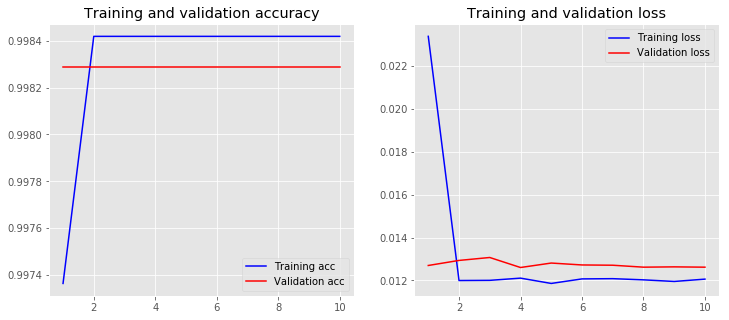

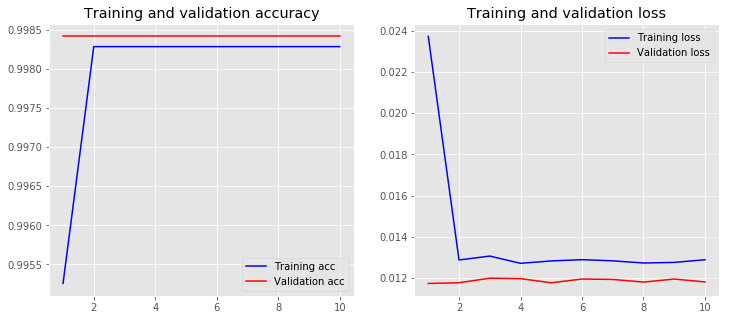

In [32]:
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    return plt
    
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

plots = []
for train, test in kfold.split(X, y):
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(X[train].shape[1], 1)))
    model.add(layers.MaxPool1D())
    model.add(layers.LSTM(units=32, dropout=0.1, recurrent_dropout=0.1))
    model.add(layers.Dense(64, activation = 'tanh',))
    model.add(layers.Dense(64, activation = 'tanh',))
    model.add(layers.Dense(64, activation = 'tanh',))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(X[train], y[train],
                        epochs=30,
                        verbose=True,
                        validation_data=(X[test], y[test]),
                        shuffle=True,
                        batch_size=32)
    
    loss, accuracy = model.evaluate(X[train], y[train], verbose=False)
    print("Training Accuracy: {:.2f}".format(accuracy))
    loss, accuracy = model.evaluate(X[test], y[test], verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plots.append(plot_history(history))
    
for plt in plots:
    plt.show()